#########################################################################
 MoRed - GeM Laboratory
 ECOLE CENTRALE DE NANTES
#########################################################################

In [ ]:
import os
import numpy as np
from scipy import sparse
import itertools
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
from pytictoc import TicToc

In [ ]:
from library import FEM_mat_1D, FEM_mat_2D

### DATA ENTRY

Similar problem as Lab1_1 but this time the thermal conductivity is a nonlinear function of the temperature T

 FIXED POINT TOLERANCE

In [ ]:
fp_tol = 1e-7

### LOAD FINITE ELEMENT MESH

  1 subtracted from connectivity tables for 0-based indexing of python

In [ ]:
connectAll = np.loadtxt('Mesh_M2/connectAll.txt', delimiter=',', dtype=int)-1
connectDown = np.loadtxt('Mesh_M2/connectDown.txt', delimiter=',', dtype=int)-1
connectHole = np.loadtxt('Mesh_M2/connectHole.txt', delimiter=',', dtype=int)-1
connectLeft = np.loadtxt('Mesh_M2/connectLeft.txt', delimiter=',', dtype=int)-1
connectRight = np.loadtxt('Mesh_M2/connectRight.txt', delimiter=',', dtype=int)-1
connectUp = np.loadtxt('Mesh_M2/connectUp.txt', delimiter=',', dtype=int)-1
nodesAll = np.loadtxt('Mesh_M2/nodesAll.txt', delimiter=',')

In [ ]:
X = nodesAll[:, 0]
Y = nodesAll[:, 1]
numOfNodes = nodesAll.shape[0]

### DEFINE TIME DISCRETIZATION

 TIME INTERVAL, TIME INCREMENT

In [ ]:
timeSpan = 1
timeInc = 0.01
time = np.linspace(0,timeSpan,int(timeSpan/timeInc)+1)
numOfFrames = time.size

### MATERIAL PROPERTIES

 conductivity, mass density, specific heat

Text(0, 0.5, 'Conductivity')

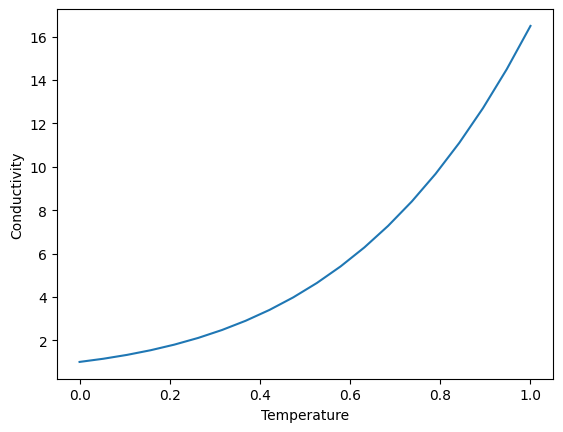

In [ ]:
k0 = 1
density = 1
specificHeat = 10
## conductivity  handle function
condfun = lambda T: k0*(1+0.5*((T+1)**5-1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(0,1, num=20), condfun(np.linspace(0,1, num=20)))
ax.set_xlabel('Temperature')
ax.set_ylabel('Conductivity')

### INITIAL AND BOUNDARY CONDITIONS

INITIAL CONDITION

In [ ]:
initialSolution = np.zeros(numOfNodes)

 DIRICHLET BC

In [ ]:
nodesDir = np.unique(np.concatenate([connectRight.reshape(-1), connectUp.reshape(-1)]))
ampliDir = np.zeros(numOfFrames)
solutionDir = np.outer(np.ones(nodesDir.size), ampliDir)

 NEWMANN BC

In [ ]:
nodesNeu = np.unique(connectHole.reshape(-1))
ampliNeu = np.sin((2*np.pi*time)/timeSpan)
ampliNeu[time>timeSpan/2] = 0
valuesNeu = np.outer(np.ones(nodesNeu.size), ampliNeu)

### SOURCE TERM

 HEAT SOURCE

In [ ]:
ampliSource = 3*np.sin(2*np.pi/timeSpan*(time-timeSpan/2))
ampliSource[time<timeSpan/2] = 0
valuesSource = np.outer(np.ones(numOfNodes), ampliSource)

### SOLVE USING FINITE ELEMENTS

 LINEAR FINITE ELEMENTS & SINGLE STEP 1st ORDER TIME INTEGRATION

 finite element operators

In [ ]:
opMass = FEM_mat_2D(nodesAll,connectAll,0,0,0,0)
opMassNeuBc = FEM_mat_1D(nodesAll,connectHole,0,0)

 dirichlet mask

In [ ]:
maskDir = np.ones(numOfNodes,dtype=bool)
maskDir[nodesDir] = False

 solution containers

In [ ]:
solutionDir[:,0] = initialSolution[~maskDir]
solutionFree = np.full([sum(maskDir),numOfFrames], np.nan)
solutionFree[:,0] = initialSolution[maskDir]

 right-hand side operators (constant throughout the time integration)

In [ ]:
opRhs = density*specificHeat*opMass
opRhsFree = opRhs[np.ix_(maskDir,maskDir)]
## right-hand side
auxSp = np.array(list(itertools.product(np.arange(0,numOfFrames),nodesNeu))) ## itertools.product returns Cartesian product of two sets
auxNeumann = sparse.lil_array((numOfNodes,numOfFrames))
for r, c, val in zip(auxSp[:,1], auxSp[:,0], valuesNeu.reshape(-1, order='F')):
    auxNeumann[r, c] = val

rhsNeumannFree = opMassNeuBc[maskDir,:] @ auxNeumann
rhsSourceFree = opMass[maskDir,:] @ valuesSource

 sum contributions

In [ ]:
rhsTotalFree = rhsNeumannFree + rhsSourceFree

Auxiliary variable used to hold Temperature fields

In [ ]:
auxT = np.full(numOfNodes, np.nan)

TIME INTEGRATION LOOP (first order single step)

In [ ]:
t = TicToc()
t.tic()
for i in range(1,numOfFrames):
    err = 1
    auxT[~maskDir]=solutionDir[:,i]
    auxT[maskDir]=solutionFree[:,i-1]
    auxRhsFree = rhsTotalFree[:,i]
    rhs = opRhsFree@solutionFree[:,i-1] + timeInc*auxRhsFree
    while err > fp_tol:
        # evaluate the conductivity field
        condfield = np.atleast_2d(condfun(auxT)).T
        Kx = FEM_mat_2D(nodesAll,connectAll,1,0,1,0,condfield)
        Ky = FEM_mat_2D(nodesAll,connectAll,0,1,0,1,condfield)
        opConduc = Kx+Ky
        opLhs = density*specificHeat*opMass + timeInc*opConduc
        opLhsFree = opLhs[np.ix_(maskDir,maskDir)]
        solutionFree[:,i] = sparse.linalg.spsolve(opLhsFree, rhs)
        err = np.linalg.norm(solutionFree[:,i]-auxT[maskDir])/np.linalg.norm(solutionFree[:,i])
        # print(f"Time step: {i:3d} of {numOfFrames:3d}, error is : {err:0.2e}")
        auxT[maskDir]=solutionFree[:,i]
    print(f"Time step: {i:3d} of {numOfFrames:3d}, error is : {err:0.2e}")

Time step:   1 of 101, error is : 4.87e-10
Time step:   2 of 101, error is : 3.60e-09
Time step:   3 of 101, error is : 1.12e-08
Time step:   4 of 101, error is : 2.44e-08
Time step:   5 of 101, error is : 4.40e-08
Time step:   6 of 101, error is : 7.01e-08
Time step:   7 of 101, error is : 3.18e-10
Time step:   8 of 101, error is : 5.25e-10
Time step:   9 of 101, error is : 8.04e-10
Time step:  10 of 101, error is : 1.16e-09
Time step:  11 of 101, error is : 1.59e-09
Time step:  12 of 101, error is : 2.09e-09
Time step:  13 of 101, error is : 2.64e-09
Time step:  14 of 101, error is : 3.24e-09
Time step:  15 of 101, error is : 3.85e-09
Time step:  16 of 101, error is : 4.46e-09
Time step:  17 of 101, error is : 5.05e-09
Time step:  18 of 101, error is : 5.58e-09
Time step:  19 of 101, error is : 6.04e-09
Time step:  20 of 101, error is : 6.41e-09
Time step:  21 of 101, error is : 6.67e-09
Time step:  22 of 101, error is : 6.81e-09
Time step:  23 of 101, error is : 6.83e-09
Time step: 

In [ ]:
execTime = t.tocvalue()
print(f"\nTime integration loop executed in {execTime:0.4f} sec\n")


Time integration loop executed in 254.9430 sec



In [ ]:
solution = np.full([numOfNodes,numOfFrames], np.nan)
solution[~maskDir,:] = solutionDir
solution[maskDir,:] = solutionFree

### POST-PROCESS

SAVE SOLUTION

In [ ]:
os.makedirs('FEM_Solution/plots', exist_ok=True)
np.savetxt('FEM_Solution/X.txt', X, delimiter=',')
np.savetxt('FEM_Solution/Y.txt', Y, delimiter=',')
np.savetxt('FEM_Solution/connectAll.txt', connectAll, delimiter=',', fmt='%5i')
np.savetxt('FEM_Solution/time.txt', time, delimiter=',')
np.savetxt('FEM_Solution/solution.txt', solution, delimiter=',')
np.savetxt('FEM_Solution/maskDir.txt', maskDir, delimiter=',', fmt='%5i')
np.savetxt('FEM_Solution/density.txt', [density], delimiter=',')
np.savetxt('FEM_Solution/k0.txt', [k0], delimiter=',')
np.savetxt('FEM_Solution/specificHeat.txt', [specificHeat], delimiter=',')

 PLOT RESULTS

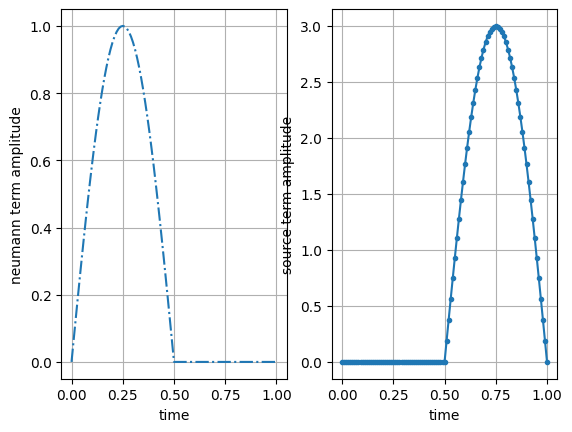

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(time, ampliNeu, linestyle='dashdot')
ax.grid()
ax.set_xlabel('time')
ax.set_ylabel('neumann term amplitude')

ax = fig.add_subplot(122)
ax.plot(time,ampliSource,'.-')
ax.grid()
ax.set_xlabel('time')
ax.set_ylabel('source term amplitude')

fig.savefig('FEM_Solution/plots/SourcesAndFluxes.png')

 PLOT TIME SOLUTION (Dynamic plots may not work on notebooks/deepnote. In that case, visualize the solution using the saved (png) figures)

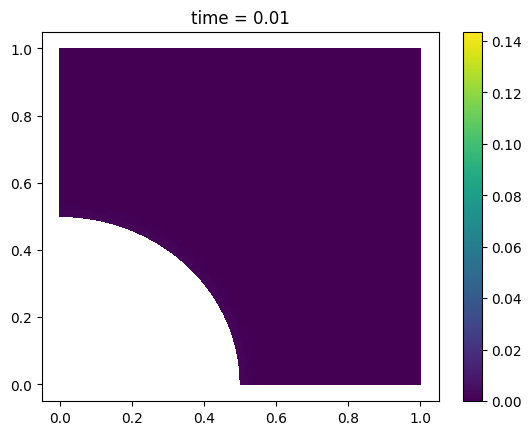

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
solution2plot = solution[:,0]
vmin = 0.9*solution.min()
vmax = 1.1*solution.max()

if connectAll.shape[1]==4:
    f1 = ax.pcolormesh([X, Y], solution2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'time = {time[0]:0.2f}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, numOfFrames):
        solution2plot = solution[:,i]
        f1.set_array(solution2plot)
        ax.set_title(f'time = {time[i]:0.2f}')
        if ((i%int(numOfFrames/10))==0) | (i==numOfFrames-1):
            fig.savefig(f'FEM_Solution/plots/SolAtTime={time[i]:0.2f}.png')
        plt.pause(5/numOfFrames)
elif connectAll.shape[1]==3:
    Tri = Triangulation(X, Y, triangles=connectAll)
    f1 = ax.tripcolor(Tri, solution2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'time = {time[0]:0.2f}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, numOfFrames):
        solution2plot = solution[:,i]
        # f1.set_array(solution2plot)
        f1 = ax.tripcolor(Tri, solution2plot, vmin=vmin, vmax=vmax)
        ax.set_title(f'time = {time[i]:0.2f}')
        if ((i%int(numOfFrames/10))==0) | (i==numOfFrames-1):
            fig.savefig(f'FEM_Solution/plots/SolAtTime={time[i]:0.2f}.png')
        plt.pause(5/numOfFrames)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6e4ec535-1a42-4f7f-9f57-76554989f508' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>